# 안녕하세요^^ 
# AIVLE 미니 프로젝트에 오신 여러분을 환영합니다.
* 본 과정에서는 실제 사례와 데이터를 기반으로 문제를 해결하는 전체 과정을 자기 주도형 실습으로 진행해볼 예정입니다.
* 앞선 교육과정을 정리하는 마음과 지금까지 배운 내용을 바탕으로 문제 해결을 해볼게요!
* 미니 프로젝트를 통한 문제 해결 과정 'A에서 Z까지', 지금부터 시작합니다!

---

## 0. 환경 설정하기

### 1) 구글 드라이브 연결하기

In [ ]:
# 코랩 사용 시 구글 드라이브 연결
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 2) 경로 확인하기
<font color="red">※ 주의. 경로는 절대 변경하지 마세요.</font>

In [ ]:
# ROOT_PATH 확인 
import os

if os.getcwd() == '/content' :
  # 구글 드라이브 사용 시 
  ROOT_PATH = "/content/drive/MyDrive/AIVLE3rd_solution/individual"
else :
  ROOT_PATH = os.path.abspath('..')

# 영상을 분할한 이미지 경로
IMAGE_PATH = ROOT_PATH + "/image"
# Train 데이터 셋 경로
TRAIN_PATH = ROOT_PATH + "/train"


### 3) 라이브러리 불러오기
필요시 추가 라이브러리는 설치해서 사용하세요.

In [ ]:
# 필요 라이브러리 불러오기.
import os
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator

# 1. 데이터 가공하기
영상을 프레임으로 분할한 이미지들을 학습에 적합하게 데이터를 가공하는 단계입니다.<br>
자신이 생각하는 규칙을 기반으로 이미지를 수정, 삭제하시면 되겠습니다.

* 데이터를 가공하는 것에는 정답이 없습니다.<br> ①'매뉴얼하게 일일이 확인하는 방법', ②'이미지 속 동일한 규칙을 찾아내는 방법' 등<br> 다양한 방법을 고민해 보고 이미지를 가공하여 보세요.


<font color="red"> ※ 데이터 가공이 추가로 필요하지 않다고 생각들 경우 그대로 진행하셔도 무관합니다. </font>



<font color="green">[실습문제]</font> 1. 영상을 프레임으로 분할한 이미지들을 학습에 적합하게 데이터를 가공해주세요. 

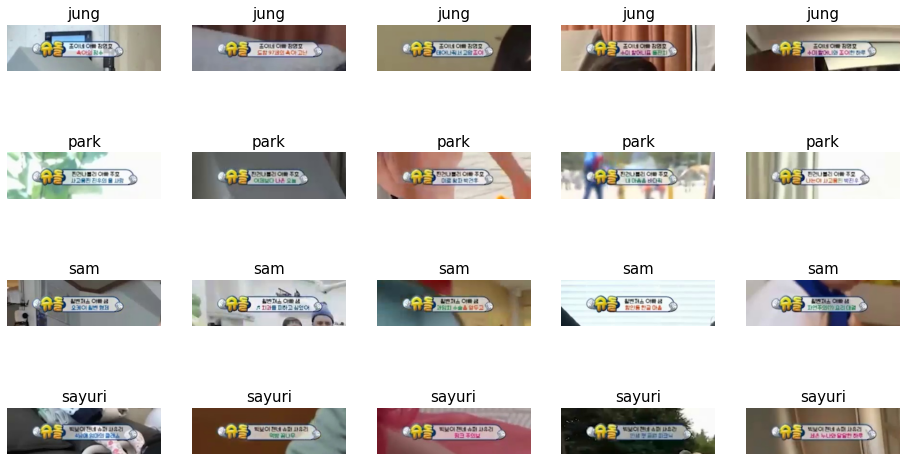

In [ ]:
# 실습해보세요.
import matplotlib.pyplot as plt
%matplotlib inline

class_map = {
    0: 'jung',
    1: 'park',    
    2: 'sam',
    3: 'sayuri',
}

image_class = glob.glob(IMAGE_PATH + "*/*")
image_class.sort()

fig, axes = plt.subplots(4, 5,figsize=(16, 9))
class_count = 0 
for c in image_class:  
  for i in range(5):
    original_image = cv2.imread(c + "/" + str(i*200) + ".jpg")
    rgb_image = cv2.cvtColor(original_image,cv2.COLOR_BGR2RGB)
    # 특정 영역만 잘라서 이미지 비교
    cropped_image = rgb_image[0:96, 0:320]
    axes[class_count, i].imshow(cropped_image)
    axes[class_count, i].set_title(class_map[class_count] , fontsize=15)    
    axes[class_count, i].axis('off')
  class_count += 1
plt.show()

In [ ]:
# [Tip] 
# 이미지 전체를 학습할 필요가 없다. 
# 코너를 구분하는데 필요한 영역은 좌측 상단에 고정되어 있음으로 해당 영역만 잘라내서 학습 데이터를 생성하는 것도 가능

def croppedImage(IMAGE_PATH):
  #이미지를 잘라낼 영역 
  bounding_box = {
      'start_x' : 0, 
      'start_y' : 0,
      'end_x' : 320,    
      'end_y' : 96
  }
  from tqdm.auto import tqdm, trange
  image_list = glob.glob(IMAGE_PATH + '/*/*.jpg')
  for image in tqdm(image_list, desc="IMAGE CROP PROGRESS"):
    original_image = cv2.imread(image)
    cropped_image = original_image[bounding_box['start_y']:bounding_box['end_y'], bounding_box['start_x']:bounding_box['end_x']]    
    cv2.imwrite(image, cropped_image) 

In [ ]:
croppedImage(IMAGE_PATH)

IMAGE CROP PROGRESS:   0%|          | 0/867 [00:00<?, ?it/s]

# 2. 학습 데이터 세트 만들기 

<font color="green">[실습문제]</font> 2. 가공이 완료된 이미지 데이터를 class 별로 데이터 세트 만들기
* class명을 출연진으로 하여 class 별로 학습 데이터 세트를 만듭니다.<br>(class명 : 'jung', 'park', 'sam', 'sayuri')
* 학습 데이터 경로 "../train/"

> [예시] 폴더 구조 <br>
> train ┐ <br>
> &emsp;&emsp; ├ jung <br>
> &emsp;&emsp; ├ park <br>
> &emsp;&emsp; ├ sam <br>
> &emsp;&emsp; ├ sayuri <br>

In [ ]:
TRAIN_PATH = ROOT_PATH + "/train"

In [ ]:
# 실습해보세요.
import shutil

shutil.copytree(IMAGE_PATH, TRAIN_PATH)

'/content/drive/MyDrive/AIVLE3rd_solution/individual/train'

# 2. 데이터 전처리
+ KeyPoint : 케라스에서는 이미지 파일을 쉽게 학습시킬 수 있도록 ImageDataGenerator 클래스를 제공합니다.


### 가. ImageDataGenerator 
+ ImageDataGenerator 클래스를 이용하여 객체를 생성한 뒤 flow_from_directory()함수를 호출하여 Generator를 생성
> + 첫번재 인자 : 이미지 경로를 지정합니다.
> + target_size : 패치 이미지 크기를 지정합니다. 폴더에 있는 원본 이미지 크기가 다르더라도 target_size에 지정된 크기로 자동 조절됩니다.
> + batch_size : 배치 크기를 지정합니다.
> + class_mode : 분류 방식에 대해서 지정합니다.
>> + categorical : 2D one-hot 부호화된 라벨이 반환됩니다.
>> + binary : 1D 이진 라벨이 반환됩니다.
>> + sparse : 1D 정수 라벨이 반환됩니다.
>> + None : 라벨이 반환되지 않습니다. 




[실습문제 2] ImageDataGenerator 생성하기
+ 모델 검증을 위해 데이터를 train:validation(8:2)로 분할합니다.
+ 모델 성능 개선을 위해 데이터 증식(Data augmentation)이 필요 시 자유롭게 설정

In [ ]:
# 실습해보세요.
import tensorflow as tf

from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator


train_datagen = ImageDataGenerator(
    rescale=1. / 255,  # 이미지 데이터 정규화
    validation_split=0.2, # train, validation 데이터 분할 (8:2)
)

In [ ]:
batch_size = 32
img_height = 96
img_width = 320

In [ ]:
# train_genrator 생성
train_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    batch_size=batch_size,
    shuffle=True,
    color_mode="grayscale",
    target_size=(img_height, img_width),    
    class_mode='categorical',
    subset='training',
)

Found 695 images belonging to 4 classes.


In [ ]:
# validation_generator 생성
validation_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
)

Found 172 images belonging to 4 classes.


In [ ]:
class_map = {
    0: 'jung',
    1: 'park',    
    2: 'sam',
    3: 'sayuri',
    }

In [ ]:
def generatorImage(generator, class_map): 
    
  for x, y in generator:
    #print(generator)
    fig, axes = plt.subplots(4, 5,figsize=(16, 9))
    for i in range(20):
      disp_x = x[i, :, :, 0]
      axes[i//5, i%5].imshow(disp_x, cmap='gray')
      axes[i//5, i%5].set_title(class_map[np.argmax(y[i])], fontsize=15)      
      axes[i//5, i%5].axis('off')
    
    plt.show()
    break

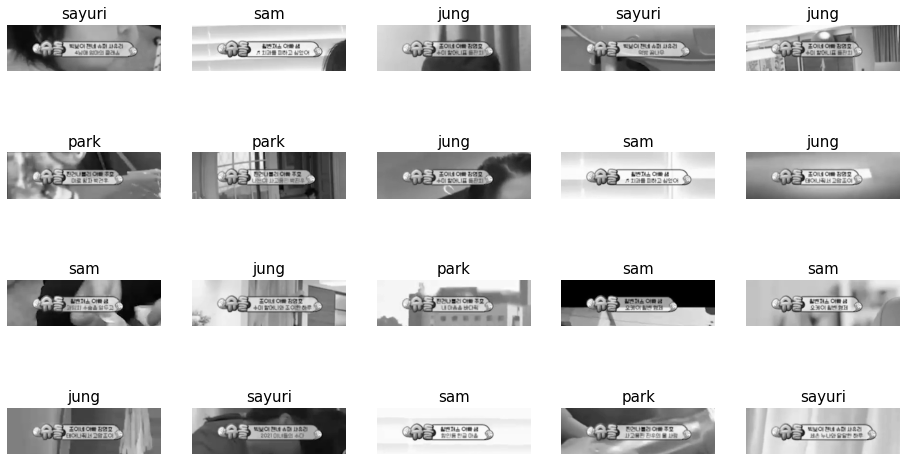

In [ ]:
generatorImage(train_generator, class_map)